<a href="https://colab.research.google.com/github/sungjuGit/STPython_IntroBayes/blob/main/MCMC_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Converted from the Julia code using Calude.ai.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from sklearn.preprocessing import StandardScaler

In [ ]:
# Set random seed
np.random.seed(1)

# Island hopping simulation
num_weeks = 10**5
positions = []
current = 10

for i in range(1, num_weeks + 1):
    # record current position
    positions.append(current)

    # flip coin to generate proposal
    proposal = current + np.random.choice([-1, 1])

    # handle loops around
    if proposal < 1:
        proposal = 10
    if proposal > 10:
        proposal = 1

    # move?
    prob_move = proposal / current
    if np.random.random() < prob_move:
        current = proposal



<Figure size 640x480 with 0 Axes>

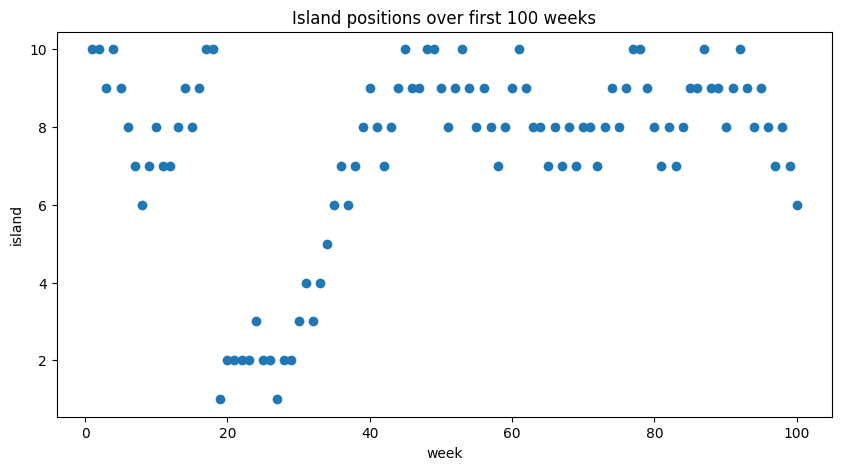

<Figure size 640x480 with 0 Axes>

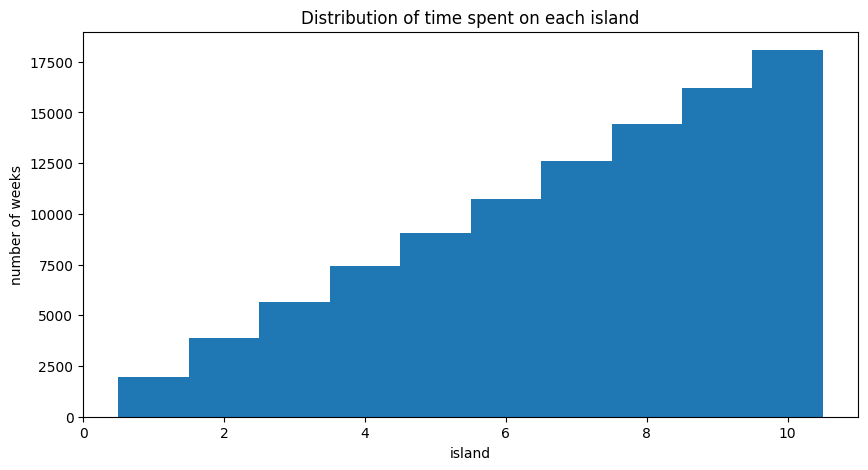

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting the first 100 positions
plt.figure(figsize=(10, 5))
plt.scatter(range(1, 101), positions[:100])
plt.xlabel("week")
plt.ylabel("island")
plt.title("Island positions over first 100 weeks")
plt.figure()

# Histogram of positions
plt.figure(figsize=(10, 5))
plt.hist(positions, bins=10, range=(0.5, 10.5))
plt.xlabel("island")
plt.ylabel("number of weeks")
plt.title("Distribution of time spent on each island")
plt.figure()

<Figure size 640x480 with 0 Axes>

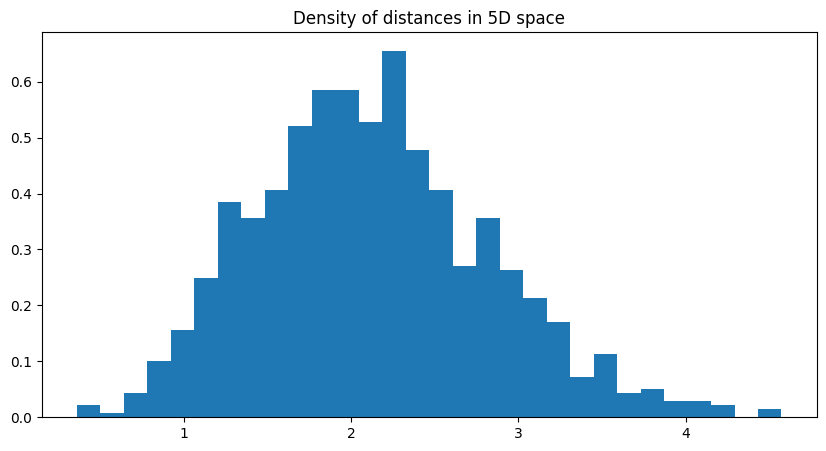

<Figure size 640x480 with 0 Axes>

In [ ]:
# Curse of dimensions
D = 5
T = 1000
Y = multivariate_normal.rvs(mean=np.zeros(D), cov=np.eye(D), size=T).T
Rd = np.sqrt(np.sum(Y**2, axis=0))
plt.figure(figsize=(10, 5))
plt.hist(Rd, bins=30, density=True)
plt.title("Density of distances in 5D space")
plt.figure()

In [ ]:
# Hamiltonian Monte Carlo
np.random.seed(7)


def normlogpdf(x, mu, sigma):
    """Log probability density function for normal distribution"""
    return norm.logpdf(x, loc=mu, scale=sigma)

def E(z, a=0, b=0.5, k=0, d=0.5):
    """Energy function (negative log probability)"""
    mu_x, mu_y = z
    E_val = sum(normlogpdf(x, mu_x, 1)) + sum(normlogpdf(y, mu_y, 1))
    E_val += normlogpdf(mu_x, a, b) + normlogpdf(mu_y, k, d)
    return -E_val

def grad_E(z, a=0, b=0.5, k=0, d=0.5):
    """Gradient of energy function"""
    mu_x, mu_y = z
    G_1 = sum(x - mu_x) / 1**2 + (a - mu_x) / b**2  # ∂U/∂μx
    G_2 = sum(y - mu_y) / 1**2 + (k - mu_y) / d**2  # ∂U/∂μy
    return np.array([-G_1, -G_2])

def HMC2(E, grad_E, epsilon, L, current_z):
    """Hamiltonian Monte Carlo sampling"""
    z = current_z.copy()
    r = np.random.normal(size=len(z))  # random flick - p is momentum
    current_r = r.copy()

    # make a half step for momentum at the beginning
    r -= epsilon * grad_E(z) / 2

    # initialize bookkeeping - saves trajectory
    ztraj = [z.copy()]
    rtraj = [r.copy()]

    # Alternate full steps for position and momentum
    for i in range(1, L+1):
        z = z + epsilon * r  # full step for the position
        # make a full step for the momentum except at the end of trajectory
        if i != L:
            r -= epsilon * grad_E(z)
            rtraj.append(r.copy())
        ztraj.append(z.copy())

    # Make a half step for momentum at the end
    r -= epsilon * grad_E(z) / 2
    rtraj.append(r.copy())

    # negate momentum at the end of trajectory to make the proposal symmetric
    r = -r

    # evaluate potential and kinetic energies at the start and the end of trajectory
    current_E_val = E(current_z)
    current_K = sum(current_r**2)/2
    proposed_E_val = E(z)
    proposed_K = sum(r**2)/2

    # accept or reject the state at the end of trajectory
    accept = (np.random.random() < np.exp(current_E_val + current_K - proposed_E_val - proposed_K))

    if accept:
        current_z = z.copy()

    return {"z": current_z, "traj": ztraj, "rtraj": rtraj, "accept": accept}



In [ ]:
np.random.seed(7)

x = np.random.normal(size=50)
y = np.random.normal(size=50)

# Standardize
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x = scaler_x.fit_transform(x.reshape(-1, 1)).flatten()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

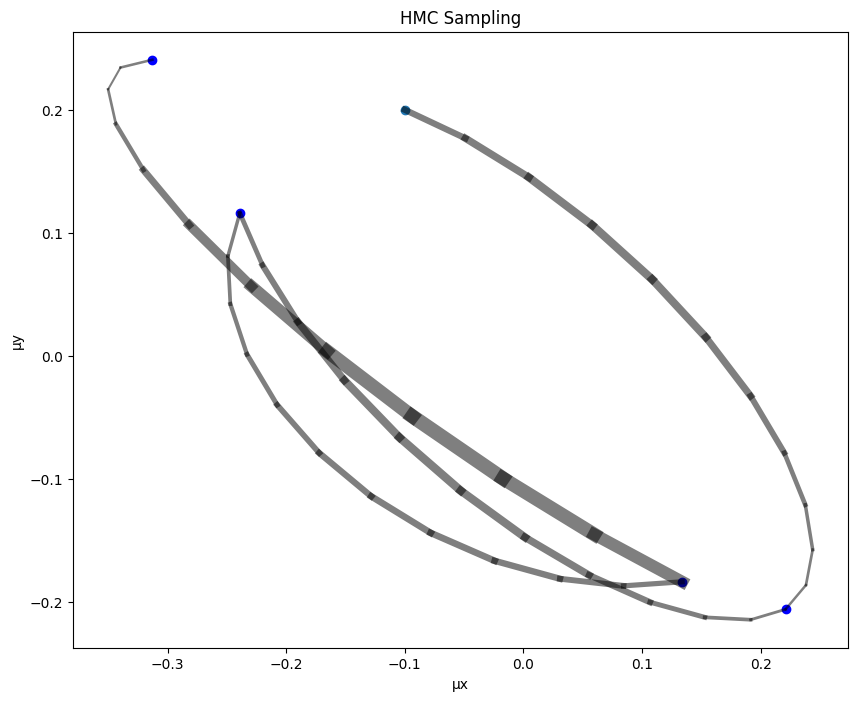

In [ ]:
# HMC sampling and plotting
np.random.seed(1)
Q = {"z": np.array([-0.1, 0.2])}  # initialize Q["z"]

step = 0.03
L = 11
n_samples = 4

# Create a plot for μx vs μy
plt.figure(figsize=(10, 8))
plt.scatter([Q["z"][0]], [Q["z"][1]], label="Start")

for i in range(1, n_samples+1):
    Q = HMC2(E, grad_E, step, L, Q["z"])

    if n_samples < 10:
        cx, cy = [], []
        for j in range(L):
            K0 = sum(Q["rtraj"][j]**2)/2  # kinetic energy
            plt.plot(
                [Q["traj"][j][0], Q["traj"][j+1][0]],
                [Q["traj"][j][1], Q["traj"][j+1][1]],
                linewidth=1+2*K0,  # line width is proportional to kinetic energy
                color='black',
                alpha=0.5
            )
            cx.append(Q["traj"][j+1][0])
            cy.append(Q["traj"][j+1][1])

        plt.scatter(cx, cy, color='white', s=9)

    marker = 'o' if Q["accept"] else 's'  # circle if accepted, square if rejected
    plt.scatter([Q["z"][0]], [Q["z"][1]], marker=marker, color='blue')

plt.xlabel("μx")
plt.ylabel("μy")
plt.title("HMC Sampling")
plt.show()